## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers  import Flatten, Dense, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
x_train = train.drop('label', axis = 1)
y_train = train['label']

In [6]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

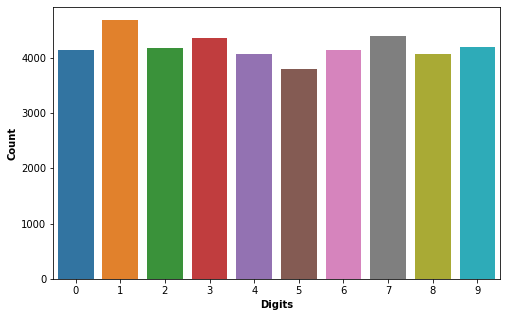

In [7]:
plt.figure(figsize = (8,5))
sns.countplot(y_train)
plt.xlabel('Digits', weight = 'bold')
plt.ylabel('Count', weight = 'bold')
plt.show()

In [8]:
# missing values check
x_train.isna().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Prepair Training Data

In [0]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
CHANNELS = 1

#### Normalization

In [0]:
x_train = x_train/255
test = test/255

#### Reshape

In [0]:
train = x_train.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1)
test = test.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1)

#### Label encoding

In [0]:
y_train = to_categorical(y_train, 10)

#### Train and Validation split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y_train, test_size = 0.20, random_state = 345)

#### Lets See Sample Image

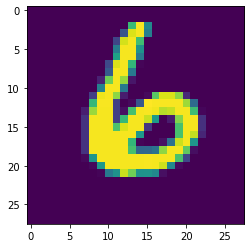

In [14]:
plt.imshow(X_train[55][:,:,0])
plt.show()

## Creating the Image Classification Model

In [15]:
# CNN Model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'Same', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation ='relu', padding = 'Same'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 128, kernel_size = (5, 5), activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation ='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Flatten())      # this converts our 2D feature maps to 1D feature vectors
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

## Early Stopping in Keras to Prevent Overfitting
<b>Overfitting</b> occurs when a neural network is trained to the point that it begins to memorize rather than generalize, as demonstrated in Figure 

In [0]:
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, 
        verbose = 1, mode = 'auto', restore_best_weights = True)

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.00001)

In [0]:
epochs = 50
batch_size = 64

## Data Augmentation

Data augmentation is required before we train the model, so as to reduce overfitting. Data augmentation means increasing the number of images in the data set. So, we will flip, zoom and do a lot of things with all the existing data set images, so that the machine will get a variety of types of images to study.

Before we train the model, we need to set the train and test directories. Keras has a method called flow() method. After we run this cell, the machine will say that it has found the images in our data set.

In [0]:
train_generator = ImageDataGenerator(rotation_range = 25,
                                     height_shift_range = False,
                                     width_shift_range = False,
                                     horizontal_flip = True,
                                     shear_range = 0.2,
                                     fill_mode = 'nearest',
                                     zoom_range = 0.1)

train_generator.fit(X_train)
train_gen = train_generator.flow(X_train, y_train, batch_size = batch_size)

## Fit Model

In [20]:
# Fit the model
history = model.fit_generator(train_gen,
                              epochs = epochs, 
                              validation_data = (X_valid, y_valid),
                              verbose = 2,
                              callbacks=[learning_rate_reduction, monitor])

Epoch 1/50
 - 17s - loss: 0.4158 - acc: 0.8654 - val_loss: 0.1143 - val_acc: 0.9629
Epoch 2/50
 - 14s - loss: 0.1579 - acc: 0.9518 - val_loss: 0.0928 - val_acc: 0.9723
Epoch 3/50
 - 14s - loss: 0.1176 - acc: 0.9646 - val_loss: 0.0845 - val_acc: 0.9742
Epoch 4/50
 - 14s - loss: 0.1001 - acc: 0.9696 - val_loss: 0.0537 - val_acc: 0.9833
Epoch 5/50
 - 14s - loss: 0.0913 - acc: 0.9731 - val_loss: 0.0744 - val_acc: 0.9806
Epoch 6/50
 - 14s - loss: 0.0869 - acc: 0.9743 - val_loss: 0.0506 - val_acc: 0.9858
Epoch 7/50
 - 14s - loss: 0.0780 - acc: 0.9768 - val_loss: 0.0544 - val_acc: 0.9830
Epoch 8/50
 - 14s - loss: 0.0741 - acc: 0.9783 - val_loss: 0.0651 - val_acc: 0.9820
Epoch 9/50
 - 14s - loss: 0.0700 - acc: 0.9801 - val_loss: 0.0569 - val_acc: 0.9843

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/50
 - 14s - loss: 0.0536 - acc: 0.9840 - val_loss: 0.0477 - val_acc: 0.9863
Epoch 11/50
 - 14s - loss: 0.0488 - acc: 0.9854 - val_loss: 0.0423 - val_acc: 

## Training and validation curves

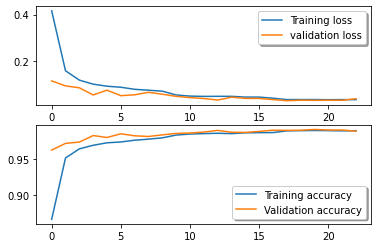

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], label = "Training loss")
ax[0].plot(history.history['val_loss'], label = "validation loss")
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(history.history['acc'], label = "Training accuracy")
ax[1].plot(history.history['val_acc'], label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)
plt.show()

### Saving Model

In [0]:
model.save_weights('model.h5')

## Testing the classifier

In [0]:
predict = model.predict(test)

In [0]:
results = np.argmax(predict, axis = 1)

In [0]:
results = pd.Series(results, name = "Label")

In [36]:
results

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

### Lets See Preticted Result

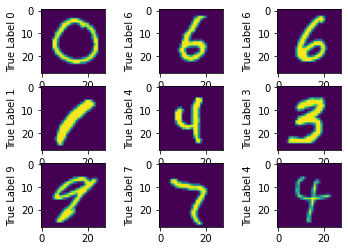

In [80]:
true_lable = results[91:100].tolist()
i = 0
for index, img in enumerate(test[91:100]):
  category = true_lable[i]
  i = i + 1
  plt.subplot(3, 3, i)
  plt.imshow(img[:,:,0])
  plt.ylabel(f"True Label {category}")

  # plt.tight_layout()
  # plt.show()



### Lets See top 6 errors Result

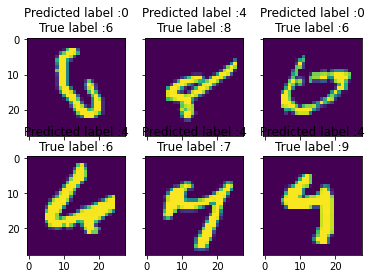

In [49]:
Y_pred = model.predict(X_valid)
Y_true = np.argmax(y_valid, axis = 1) 

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_valid[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis = 1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

From the above plot we can see that Some of these errors can be made by humans also. 